In [1]:
import os
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers, models

In [2]:
csv_path = 'combined_labels_old.csv'
df = pd.read_csv(csv_path)
df.head()

,File Name,Label
0,common_voice_ta_31833527.wav,Tamil
1,common_voice_en_38025497.wav,English
2,common_voice_ta_31833176.wav,Tamil
3,common_voice_fr_34952338.wav,French
4,common_voice_en_38025197.wav,English


In [3]:
shuffled_df = df.sample(frac=1).reset_index(drop=True)
shuffled_df

,File Name,Label
0,common_voice_en_38024680.wav,English
1,common_voice_de_36532746.wav,German
2,common_voice_fr_34932149.wav,French
3,common_voice_en_38024645.wav,English
4,common_voice_fr_34929485.wav,French
...,...,...
1995,common_voice_ta_31838038.wav,Tamil
1996,common_voice_de_36532464.wav,German
1997,common_voice_fr_34930408.wav,French
1998,common_voice_en_38024685.wav,English


In [4]:
audio_dir = 'Data'

In [5]:
def load_and_preprocess(file_path):
    audio, _ = librosa.load(file_path, res_type='kaiser_fast', duration=2.5, sr=22050, offset=0.5)
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=13)
    return mfccs

In [6]:
# Create a list to store MFCCs and labels
mfccs_list = []
labels = []

In [29]:
for index, row in shuffled_df.iterrows():
    file_path = os.path.join(audio_dir, row['File Name'])
    mfccs = load_and_preprocess(file_path)
    mfccs_list.append(mfccs.T)
    labels.append(row['Label'])

In [30]:
print(len(mfccs_list))
print(len(labels))

4000
4000


In [31]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_mfccs = pad_sequences(mfccs_list, dtype='float32', padding='post', truncating='post')

print(padded_mfccs.shape)

(4000, 108, 13)


In [32]:
X = np.array(padded_mfccs)
y = np.array(labels)

In [33]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [35]:

from tensorflow.keras import regularizers
model_rnn = models.Sequential([
    layers.Input(shape=(X.shape[1], X.shape[2])),
    layers.GRU(64, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.1),
    layers.GRU(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.1),
    layers.Dense(5, activation='softmax')
])


In [36]:
'''
from tensorflow.keras import regularizers
model_rnn = models.Sequential([
    layers.Input(shape=(X.shape[1], X.shape[2])),
    layers.GRU(64, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.01)),
    layers.GRU(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(5, activation='softmax')
])
'''

"\nfrom tensorflow.keras import regularizers\nmodel_rnn = models.Sequential([\n    layers.Input(shape=(X.shape[1], X.shape[2])),\n    layers.GRU(64, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.01)),\n    layers.GRU(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),\n    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),\n    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),\n    layers.Dense(5, activation='softmax')\n])\n"

In [37]:
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 108, 64)           15168     
                                                                 
 dropout_4 (Dropout)         (None, 108, 64)           0         
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)               

In [38]:
model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [39]:
history = model_rnn.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/40
100/100 [==============================] - 8s 62ms/step - loss: 4.6479 - accuracy: 0.2559 - val_loss: 2.7201 - val_accuracy: 0.4350
Epoch 2/40
100/100 [==============================] - 6s 59ms/step - loss: 2.7412 - accuracy: 0.3728 - val_loss: 2.3336 - val_accuracy: 0.5038
Epoch 3/40
100/100 [==============================] - 6s 59ms/step - loss: 2.2949 - accuracy: 0.4906 - val_loss: 1.9932 - val_accuracy: 0.6338
Epoch 4/40
100/100 [==============================] - 6s 59ms/step - loss: 1.9724 - accuracy: 0.6078 - val_loss: 1.7046 - val_accuracy: 0.7088
Epoch 5/40
100/100 [==============================] - 6s 60ms/step - loss: 1.7148 - accuracy: 0.6772 - val_loss: 1.4691 - val_accuracy: 0.7900
Epoch 6/40
100/100 [==============================] - 6s 59ms/step - loss: 1.5129 - accuracy: 0.7337 - val_loss: 1.3472 - val_accuracy: 0.7962
Epoch 7/40
100/100 [==============================] - 6s 60ms/step - loss: 1.3531 - accuracy: 0.7759 - val_loss: 1.2188 - val_accuracy: 0.8325

<Figure size 1200x400 with 0 Axes>

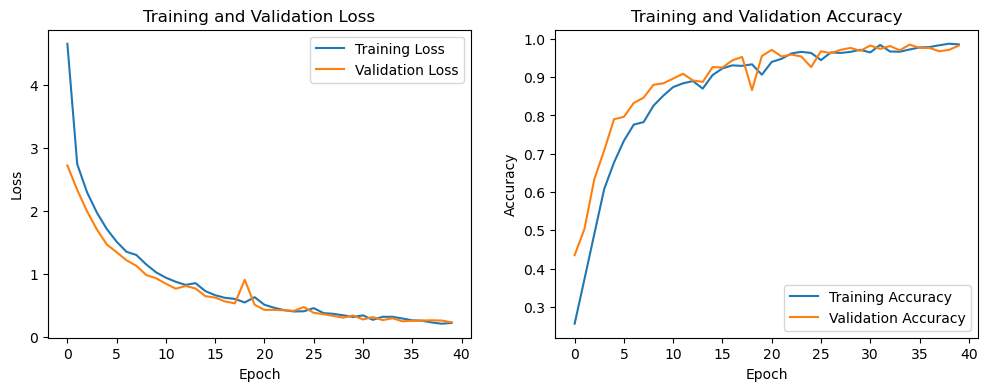

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.figure(figsize=(12, 4))

# Plot Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [41]:
from sklearn.metrics import classification_report

In [42]:
y_pred_prob = model_rnn.predict(X_test)

25/25 [==============================] - 1s 25ms/step


In [43]:
y_pred_labels = np.argmax(y_pred_prob, axis=1)

In [44]:
y_test_labels = le.inverse_transform(y_test)

In [45]:
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.9825


In [46]:
from sklearn.metrics import classification_report

In [47]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       161
           1       0.98      0.95      0.97       164
           2       0.99      0.99      0.99       148
           3       0.99      0.99      0.99       163
           4       1.00      1.00      1.00       164

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



In [48]:
test_audio_path = 'english_test_audio.wav'
test_mfccs = load_and_preprocess(test_audio_path)

padded_test_mfccs = pad_sequences([test_mfccs.T], dtype='float32', padding='post', truncating='post')

X_test_sample = np.array(padded_test_mfccs)
predictions = model_rnn.predict(X_test_sample)

predicted_label_index = np.argmax(predictions)
predicted_label = le.inverse_transform([predicted_label_index])[0]

print(f'Predicted Language: {predicted_label}')

1/1 [==============================] - 0s 307ms/step
Predicted Language: Portuguese


In [49]:
test_folder_path = 'English_test_Vox'

english_count = 0

# Iterate through all WAV files in the folder
for filename in os.listdir(test_folder_path):
    if filename.endswith(".wav"):
        test_audio_path = os.path.join(test_folder_path, filename)

        test_mfccs = load_and_preprocess(test_audio_path)
        padded_test_mfccs = pad_sequences([test_mfccs.T], dtype='float32', padding='post', truncating='post')

        X_test_sample = np.array(padded_test_mfccs)

        
        predictions = model_rnn.predict(X_test_sample)

        
        predicted_label_index = np.argmax(predictions)
        predicted_label = le.inverse_transform([predicted_label_index])[0]

        print(f'File: {filename}, Predicted Language: {predicted_label}')

        if predicted_label == 'English':
            english_count += 1


1/1 [==============================] - 0s 320ms/step
File: common_voice_en_39198183.wav, Predicted Language: German
1/1 [==============================] - 0s 31ms/step
File: common_voice_en_39198190.wav, Predicted Language: English
1/1 [==============================] - 0s 32ms/step
File: common_voice_en_39198191.wav, Predicted Language: English
1/1 [==============================] - 0s 33ms/step
File: common_voice_en_39198192.wav, Predicted Language: English
1/1 [==============================] - 0s 33ms/step
File: common_voice_en_39198193.wav, Predicted Language: German
1/1 [==============================] - 0s 34ms/step
File: common_voice_en_39198194.wav, Predicted Language: English
1/1 [==============================] - 0s 34ms/step
File: common_voice_en_39198195.wav, Predicted Language: English
1/1 [==============================] - 0s 35ms/step
File: common_voice_en_39198196.wav, Predicted Language: English
1/1 [==============================] - 0s 34ms/step
File: common_voice_en

1/1 [==============================] - 0s 33ms/step
File: common_voice_en_39201948.wav, Predicted Language: French
1/1 [==============================] - 0s 33ms/step
File: common_voice_en_39201949.wav, Predicted Language: English
1/1 [==============================] - 0s 34ms/step
File: common_voice_en_39201950.wav, Predicted Language: English
1/1 [==============================] - 0s 33ms/step
File: common_voice_en_39201951.wav, Predicted Language: English
1/1 [==============================] - 0s 33ms/step
File: common_voice_en_39201952.wav, Predicted Language: Tamil
1/1 [==============================] - 0s 34ms/step
File: common_voice_en_39201955.wav, Predicted Language: French
1/1 [==============================] - 0s 33ms/step
File: common_voice_en_39201958.wav, Predicted Language: English
1/1 [==============================] - 0s 34ms/step
File: common_voice_en_39201961.wav, Predicted Language: French
1/1 [==============================] - 0s 34ms/step
File: common_voice_en_392

1/1 [==============================] - 0s 36ms/step
File: common_voice_en_39202266.wav, Predicted Language: English
1/1 [==============================] - 0s 36ms/step
File: common_voice_en_39202267.wav, Predicted Language: English
1/1 [==============================] - 0s 36ms/step
File: common_voice_en_39202268.wav, Predicted Language: English
1/1 [==============================] - 0s 35ms/step
File: common_voice_en_39202269.wav, Predicted Language: English
1/1 [==============================] - 0s 37ms/step
File: common_voice_en_39202319.wav, Predicted Language: English
1/1 [==============================] - 0s 35ms/step
File: common_voice_en_39202322.wav, Predicted Language: English
1/1 [==============================] - 0s 33ms/step
File: common_voice_en_39202324.wav, Predicted Language: English
1/1 [==============================] - 0s 34ms/step
File: common_voice_en_39202326.wav, Predicted Language: English
1/1 [==============================] - 0s 37ms/step
File: common_voice_e

In [50]:
print(f'Total English Predictions: {english_count}')

Total English Predictions: 130


## Time segment prediction

In [51]:
def load_and_preprocess_segment(file_path, start_time, end_time):
    audio, _ = librosa.load(file_path, res_type='kaiser_fast', sr=22050, offset=start_time, duration=(end_time - start_time))
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=13)
    return mfccs

In [52]:
test_folder_path = 'English_test_Vox'

In [53]:
segment_counts = {'0-3 sec': 0, '0-6 sec': 0, '0-9 sec': 0, '0-12 sec': 0, '0-15 sec': 0}

In [54]:
for filename in os.listdir(test_folder_path):
    if filename.endswith(".wav"):
        test_audio_path = os.path.join(test_folder_path, filename)

        # Define segment durations
        segment_durations = [(0, 3), (0, 6), (0, 9), (0, 12), (0, 15)]

        # Iterate through each segment duration
        for start_time, end_time in segment_durations:
            # Load and preprocess audio segment
            segment_mfccs = load_and_preprocess_segment(test_audio_path, start_time, end_time)
            padded_test_mfccs = pad_sequences([segment_mfccs.T], dtype='float32', padding='post', truncating='post')

            X_test_sample = np.array(padded_test_mfccs)

            # Use the trained model to make predictions
            predictions = model_rnn.predict(X_test_sample)

            # Convert the predicted labels back to the original class labels
            predicted_label_index = np.argmax(predictions)
            predicted_label = le.inverse_transform([predicted_label_index])[0]

            print(f'File: {filename}, Segment: {start_time}-{end_time} sec, Predicted Language: {predicted_label}')

            # Check if the predicted label is 'English' and update the count
            if predicted_label == 'English':
                segment_counts[f'{start_time}-{end_time} sec'] += 1

1/1 [==============================] - 0s 38ms/step
File: common_voice_en_39198183.wav, Segment: 0-3 sec, Predicted Language: Portuguese
1/1 [==============================] - 0s 38ms/step
File: common_voice_en_39198183.wav, Segment: 0-6 sec, Predicted Language: Portuguese
1/1 [==============================] - 0s 39ms/step
File: common_voice_en_39198183.wav, Segment: 0-9 sec, Predicted Language: Portuguese
1/1 [==============================] - 0s 37ms/step
File: common_voice_en_39198183.wav, Segment: 0-12 sec, Predicted Language: Portuguese
1/1 [==============================] - 0s 36ms/step
File: common_voice_en_39198183.wav, Segment: 0-15 sec, Predicted Language: Portuguese
1/1 [==============================] - 0s 38ms/step
File: common_voice_en_39198190.wav, Segment: 0-3 sec, Predicted Language: French
1/1 [==============================] - 0s 51ms/step
File: common_voice_en_39198190.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 51ms

1/1 [==============================] - 0s 42ms/step
File: common_voice_en_39198206.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 41ms/step
File: common_voice_en_39198206.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 39ms/step
File: common_voice_en_39198206.wav, Segment: 0-12 sec, Predicted Language: English
1/1 [==============================] - 0s 39ms/step
File: common_voice_en_39198206.wav, Segment: 0-15 sec, Predicted Language: English
1/1 [==============================] - 0s 37ms/step
File: common_voice_en_39198207.wav, Segment: 0-3 sec, Predicted Language: Portuguese
1/1 [==============================] - 0s 38ms/step
File: common_voice_en_39198207.wav, Segment: 0-6 sec, Predicted Language: Portuguese
1/1 [==============================] - 0s 37ms/step
File: common_voice_en_39198207.wav, Segment: 0-9 sec, Predicted Language: Portuguese
1/1 [==============================] - 0s 38ms/step

1/1 [==============================] - 0s 47ms/step
File: common_voice_en_39198235.wav, Segment: 0-9 sec, Predicted Language: French
1/1 [==============================] - 0s 53ms/step
File: common_voice_en_39198235.wav, Segment: 0-12 sec, Predicted Language: French
1/1 [==============================] - 0s 50ms/step
File: common_voice_en_39198235.wav, Segment: 0-15 sec, Predicted Language: French
1/1 [==============================] - 0s 41ms/step
File: common_voice_en_39198236.wav, Segment: 0-3 sec, Predicted Language: English
1/1 [==============================] - 0s 59ms/step
File: common_voice_en_39198236.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 60ms/step
File: common_voice_en_39198236.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 59ms/step
File: common_voice_en_39198236.wav, Segment: 0-12 sec, Predicted Language: English
1/1 [==============================] - 0s 61ms/step
File: comm

1/1 [==============================] - 0s 55ms/step
File: common_voice_en_39198277.wav, Segment: 0-12 sec, Predicted Language: Portuguese
1/1 [==============================] - 0s 56ms/step
File: common_voice_en_39198277.wav, Segment: 0-15 sec, Predicted Language: Portuguese
1/1 [==============================] - 0s 40ms/step
File: common_voice_en_39198278.wav, Segment: 0-3 sec, Predicted Language: English
1/1 [==============================] - 0s 43ms/step
File: common_voice_en_39198278.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 41ms/step
File: common_voice_en_39198278.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 40ms/step
File: common_voice_en_39198278.wav, Segment: 0-12 sec, Predicted Language: English
1/1 [==============================] - 0s 40ms/step
File: common_voice_en_39198278.wav, Segment: 0-15 sec, Predicted Language: English
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 43ms/step
File: common_voice_en_39198310.wav, Segment: 0-15 sec, Predicted Language: French
1/1 [==============================] - 0s 38ms/step
File: common_voice_en_39198311.wav, Segment: 0-3 sec, Predicted Language: English
1/1 [==============================] - 0s 40ms/step
File: common_voice_en_39198311.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 42ms/step
File: common_voice_en_39198311.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 45ms/step
File: common_voice_en_39198311.wav, Segment: 0-12 sec, Predicted Language: English
1/1 [==============================] - 0s 42ms/step
File: common_voice_en_39198311.wav, Segment: 0-15 sec, Predicted Language: English
1/1 [==============================] - 0s 38ms/step
File: common_voice_en_39198312.wav, Segment: 0-3 sec, Predicted Language: English
1/1 [==============================] - 0s 54ms/step
File: co

1/1 [==============================] - 0s 37ms/step
File: common_voice_en_39201893.wav, Segment: 0-3 sec, Predicted Language: English
1/1 [==============================] - 0s 55ms/step
File: common_voice_en_39201893.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 59ms/step
File: common_voice_en_39201893.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 56ms/step
File: common_voice_en_39201893.wav, Segment: 0-12 sec, Predicted Language: English
1/1 [==============================] - 0s 61ms/step
File: common_voice_en_39201893.wav, Segment: 0-15 sec, Predicted Language: English
1/1 [==============================] - 0s 38ms/step
File: common_voice_en_39201896.wav, Segment: 0-3 sec, Predicted Language: English
1/1 [==============================] - 0s 37ms/step
File: common_voice_en_39201896.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 39ms/step
File: co

1/1 [==============================] - 0s 46ms/step
File: common_voice_en_39201950.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 47ms/step
File: common_voice_en_39201950.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 48ms/step
File: common_voice_en_39201950.wav, Segment: 0-12 sec, Predicted Language: English
1/1 [==============================] - 0s 47ms/step
File: common_voice_en_39201950.wav, Segment: 0-15 sec, Predicted Language: English
1/1 [==============================] - 0s 37ms/step
File: common_voice_en_39201951.wav, Segment: 0-3 sec, Predicted Language: English
1/1 [==============================] - 0s 56ms/step
File: common_voice_en_39201951.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 56ms/step
File: common_voice_en_39201951.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 55ms/step
File: co

1/1 [==============================] - 0s 45ms/step
File: common_voice_en_39201972.wav, Segment: 0-9 sec, Predicted Language: French
1/1 [==============================] - 0s 44ms/step
File: common_voice_en_39201972.wav, Segment: 0-12 sec, Predicted Language: French
1/1 [==============================] - 0s 44ms/step
File: common_voice_en_39201972.wav, Segment: 0-15 sec, Predicted Language: French
1/1 [==============================] - 0s 38ms/step
File: common_voice_en_39201994.wav, Segment: 0-3 sec, Predicted Language: French
1/1 [==============================] - 0s 53ms/step
File: common_voice_en_39201994.wav, Segment: 0-6 sec, Predicted Language: French
1/1 [==============================] - 0s 65ms/step
File: common_voice_en_39201994.wav, Segment: 0-9 sec, Predicted Language: German
1/1 [==============================] - 0s 65ms/step
File: common_voice_en_39201994.wav, Segment: 0-12 sec, Predicted Language: German
1/1 [==============================] - 0s 64ms/step
File: common_v

1/1 [==============================] - 0s 50ms/step
File: common_voice_en_39202043.wav, Segment: 0-12 sec, Predicted Language: English
1/1 [==============================] - 0s 52ms/step
File: common_voice_en_39202043.wav, Segment: 0-15 sec, Predicted Language: English
1/1 [==============================] - 0s 37ms/step
File: common_voice_en_39202044.wav, Segment: 0-3 sec, Predicted Language: English
1/1 [==============================] - 0s 54ms/step
File: common_voice_en_39202044.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 57ms/step
File: common_voice_en_39202044.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 55ms/step
File: common_voice_en_39202044.wav, Segment: 0-12 sec, Predicted Language: English
1/1 [==============================] - 0s 56ms/step
File: common_voice_en_39202044.wav, Segment: 0-15 sec, Predicted Language: English
1/1 [==============================] - 0s 36ms/step
File: 

1/1 [==============================] - 0s 52ms/step
File: common_voice_en_39202119.wav, Segment: 0-15 sec, Predicted Language: English
1/1 [==============================] - 0s 38ms/step
File: common_voice_en_39202120.wav, Segment: 0-3 sec, Predicted Language: English
1/1 [==============================] - 0s 42ms/step
File: common_voice_en_39202120.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 41ms/step
File: common_voice_en_39202120.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 42ms/step
File: common_voice_en_39202120.wav, Segment: 0-12 sec, Predicted Language: English
1/1 [==============================] - 0s 41ms/step
File: common_voice_en_39202120.wav, Segment: 0-15 sec, Predicted Language: English
1/1 [==============================] - 0s 38ms/step
File: common_voice_en_39202131.wav, Segment: 0-3 sec, Predicted Language: French
1/1 [==============================] - 0s 53ms/step
File: co

1/1 [==============================] - 0s 37ms/step
File: common_voice_en_39202169.wav, Segment: 0-3 sec, Predicted Language: English
1/1 [==============================] - 0s 52ms/step
File: common_voice_en_39202169.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 51ms/step
File: common_voice_en_39202169.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 51ms/step
File: common_voice_en_39202169.wav, Segment: 0-12 sec, Predicted Language: English
1/1 [==============================] - 0s 51ms/step
File: common_voice_en_39202169.wav, Segment: 0-15 sec, Predicted Language: English
1/1 [==============================] - 0s 38ms/step
File: common_voice_en_39202170.wav, Segment: 0-3 sec, Predicted Language: English
1/1 [==============================] - 0s 53ms/step
File: common_voice_en_39202170.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 69ms/step
File: co

1/1 [==============================] - 0s 53ms/step
File: common_voice_en_39202216.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 64ms/step
File: common_voice_en_39202216.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 65ms/step
File: common_voice_en_39202216.wav, Segment: 0-12 sec, Predicted Language: English
1/1 [==============================] - 0s 64ms/step
File: common_voice_en_39202216.wav, Segment: 0-15 sec, Predicted Language: English
1/1 [==============================] - 0s 37ms/step
File: common_voice_en_39202217.wav, Segment: 0-3 sec, Predicted Language: English
1/1 [==============================] - 0s 45ms/step
File: common_voice_en_39202217.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 47ms/step
File: common_voice_en_39202217.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 49ms/step
File: co

1/1 [==============================] - 0s 39ms/step
File: common_voice_en_39202319.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 39ms/step
File: common_voice_en_39202319.wav, Segment: 0-12 sec, Predicted Language: English
1/1 [==============================] - 0s 41ms/step
File: common_voice_en_39202319.wav, Segment: 0-15 sec, Predicted Language: English
1/1 [==============================] - 0s 37ms/step
File: common_voice_en_39202322.wav, Segment: 0-3 sec, Predicted Language: English
1/1 [==============================] - 0s 52ms/step
File: common_voice_en_39202322.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 52ms/step
File: common_voice_en_39202322.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 53ms/step
File: common_voice_en_39202322.wav, Segment: 0-12 sec, Predicted Language: English
1/1 [==============================] - 0s 53ms/step
File: c

1/1 [==============================] - 0s 86ms/step
File: common_voice_en_39202370.wav, Segment: 0-12 sec, Predicted Language: Tamil
1/1 [==============================] - 0s 102ms/step
File: common_voice_en_39202370.wav, Segment: 0-15 sec, Predicted Language: Tamil
1/1 [==============================] - 0s 36ms/step
File: common_voice_en_39202371.wav, Segment: 0-3 sec, Predicted Language: English
1/1 [==============================] - 0s 48ms/step
File: common_voice_en_39202371.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 49ms/step
File: common_voice_en_39202371.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 48ms/step
File: common_voice_en_39202371.wav, Segment: 0-12 sec, Predicted Language: English
1/1 [==============================] - 0s 48ms/step
File: common_voice_en_39202371.wav, Segment: 0-15 sec, Predicted Language: English
1/1 [==============================] - 0s 38ms/step
File: com

1/1 [==============================] - 0s 37ms/step
File: common_voice_en_39202382.wav, Segment: 0-15 sec, Predicted Language: German
1/1 [==============================] - 0s 40ms/step
File: common_voice_en_39202383.wav, Segment: 0-3 sec, Predicted Language: English
1/1 [==============================] - 0s 50ms/step
File: common_voice_en_39202383.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 51ms/step
File: common_voice_en_39202383.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 51ms/step
File: common_voice_en_39202383.wav, Segment: 0-12 sec, Predicted Language: English
1/1 [==============================] - 0s 50ms/step
File: common_voice_en_39202383.wav, Segment: 0-15 sec, Predicted Language: English
1/1 [==============================] - 0s 39ms/step
File: common_voice_en_39202384.wav, Segment: 0-3 sec, Predicted Language: German
1/1 [==============================] - 0s 48ms/step
File: com

1/1 [==============================] - 0s 40ms/step
File: common_voice_en_39202395.wav, Segment: 0-3 sec, Predicted Language: Tamil
1/1 [==============================] - 0s 56ms/step
File: common_voice_en_39202395.wav, Segment: 0-6 sec, Predicted Language: Tamil
1/1 [==============================] - 0s 71ms/step
File: common_voice_en_39202395.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 91ms/step
File: common_voice_en_39202395.wav, Segment: 0-12 sec, Predicted Language: English
1/1 [==============================] - 0s 108ms/step
File: common_voice_en_39202395.wav, Segment: 0-15 sec, Predicted Language: Tamil
1/1 [==============================] - 0s 39ms/step
File: common_voice_en_39202396.wav, Segment: 0-3 sec, Predicted Language: English
1/1 [==============================] - 0s 57ms/step
File: common_voice_en_39202396.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 57ms/step
File: common_

1/1 [==============================] - 0s 45ms/step
File: common_voice_en_39202407.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 44ms/step
File: common_voice_en_39202407.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 44ms/step
File: common_voice_en_39202407.wav, Segment: 0-12 sec, Predicted Language: English
1/1 [==============================] - 0s 46ms/step
File: common_voice_en_39202407.wav, Segment: 0-15 sec, Predicted Language: English
1/1 [==============================] - 0s 38ms/step
File: common_voice_en_39202408.wav, Segment: 0-3 sec, Predicted Language: English
1/1 [==============================] - 0s 42ms/step
File: common_voice_en_39202408.wav, Segment: 0-6 sec, Predicted Language: English
1/1 [==============================] - 0s 38ms/step
File: common_voice_en_39202408.wav, Segment: 0-9 sec, Predicted Language: English
1/1 [==============================] - 0s 48ms/step
File: co

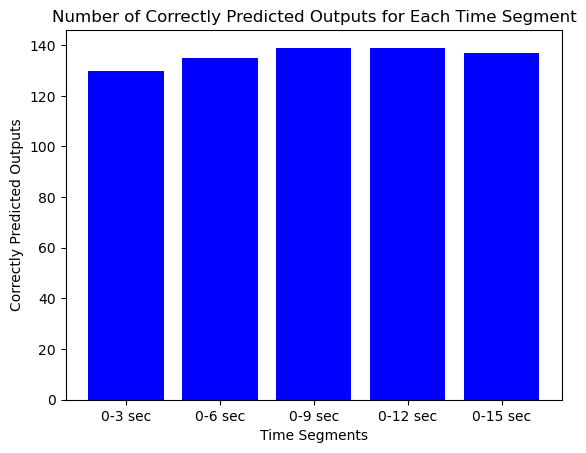

In [55]:
segments, counts = zip(*segment_counts.items())
plt.bar(segments, counts, color='blue')
plt.xlabel('Time Segments')
plt.ylabel('Correctly Predicted Outputs')
plt.title('Number of Correctly Predicted Outputs for Each Time Segment')
plt.show()

In [56]:
test_folder_path = 'German_test_Vox'

German_count = 0

for filename in os.listdir(test_folder_path):
    if filename.endswith(".wav"):
        test_audio_path = os.path.join(test_folder_path, filename)

        test_mfccs = load_and_preprocess(test_audio_path)
        padded_test_mfccs = pad_sequences([test_mfccs.T], dtype='float32', padding='post', truncating='post')

        X_test_sample = np.array(padded_test_mfccs)

        
        predictions = model_rnn.predict(X_test_sample)

        
        predicted_label_index = np.argmax(predictions)
        predicted_label = le.inverse_transform([predicted_label_index])[0]

        print(f'File: {filename}, Predicted Language: {predicted_label}')

        if predicted_label == 'German':
            German_count += 1


1/1 [==============================] - 0s 27ms/step
File: 0GLLVyNCo3Y__U__S1---0004.530-0021.000.wav, Predicted Language: English
1/1 [==============================] - 0s 30ms/step
File: 0GLLVyNCo3Y__U__S4---0021.000-0037.560.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 30ms/step
File: 0GLLVyNCo3Y__U__S4---0037.560-0053.560.wav, Predicted Language: German
1/1 [==============================] - 0s 30ms/step
File: 0MsifTxSdKw__U__S0---0150.320-0163.790.wav, Predicted Language: English
1/1 [==============================] - 0s 31ms/step
File: 0MsifTxSdKw__U__S0---0164.400-0179.760.wav, Predicted Language: English
1/1 [==============================] - 0s 31ms/step
File: 0MsifTxSdKw__U__S0---0251.380-0261.620.wav, Predicted Language: English
1/1 [==============================] - 0s 31ms/step
File: 0MsifTxSdKw__U__S0---0398.450-0406.110.wav, Predicted Language: English
1/1 [==============================] - 0s 31ms/step
File: 0MsifTxSdKw__U__S0---0406.110-

1/1 [==============================] - 0s 33ms/step
File: _zTNE3kvaGg__U__S108---0915.050-0922.230.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 33ms/step
File: _zTNE3kvaGg__U__S108---0928.770-0935.790.wav, Predicted Language: English
1/1 [==============================] - 0s 34ms/step
File: _zTNE3kvaGg__U__S108---0937.030-0940.360.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 33ms/step
File: _zTNE3kvaGg__U__S108---0940.360-0946.000.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 33ms/step
File: _zTNE3kvaGg__U__S108---0946.000-0964.760.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 35ms/step
File: _zTNE3kvaGg__U__S108---0964.760-0975.170.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 34ms/step
File: _zTNE3kvaGg__U__S150---0984.770-0991.090.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 32ms/step
File: 

In [57]:
print(f'Total German Predictions: {German_count}')

Total German Predictions: 1


In [36]:
test_folder_path = 'Tamil_test_Vox'

Tamil_count = 0

for filename in os.listdir(test_folder_path):
    if filename.endswith(".wav"):
        test_audio_path = os.path.join(test_folder_path, filename)

        test_mfccs = load_and_preprocess(test_audio_path)
        padded_test_mfccs = pad_sequences([test_mfccs.T], dtype='float32', padding='post', truncating='post')

        X_test_sample = np.array(padded_test_mfccs)

        
        predictions = model_rnn.predict(X_test_sample)

        
        predicted_label_index = np.argmax(predictions)
        predicted_label = le.inverse_transform([predicted_label_index])[0]

        print(f'File: {filename}, Predicted Language: {predicted_label}')

        if predicted_label == 'Tamil':
            Tamil_count += 1

1/1 [==============================] - 0s 32ms/step
File: _dlRllRF_j4__U__S1---0009.370-0014.020.wav, Predicted Language: German
1/1 [==============================] - 0s 33ms/step
File: _dlRllRF_j4__U__S1---0015.440-0023.380.wav, Predicted Language: English
1/1 [==============================] - 0s 33ms/step
File: _dlRllRF_j4__U__S1---0023.390-0035.040.wav, Predicted Language: German
1/1 [==============================] - 0s 32ms/step
File: _dlRllRF_j4__U__S1---0035.660-0040.820.wav, Predicted Language: English
1/1 [==============================] - 0s 33ms/step
File: _dlRllRF_j4__U__S27---0042.550-0048.650.wav, Predicted Language: English
1/1 [==============================] - 0s 32ms/step
File: _dlRllRF_j4__U__S27---0053.050-0058.340.wav, Predicted Language: German
1/1 [==============================] - 0s 34ms/step
File: _dlRllRF_j4__U__S27---0066.970-0071.070.wav, Predicted Language: English
1/1 [==============================] - 0s 34ms/step
File: _dlRllRF_j4__U__S27---0084.580-0

1/1 [==============================] - 0s 32ms/step
File: _etS1EO0WKw__U__S38---0173.140-0178.440.wav, Predicted Language: German
1/1 [==============================] - 0s 33ms/step
File: _etS1EO0WKw__U__S38---0178.470-0186.030.wav, Predicted Language: English
1/1 [==============================] - 0s 32ms/step
File: _etS1EO0WKw__U__S38---0186.300-0195.200.wav, Predicted Language: English
1/1 [==============================] - 0s 33ms/step
File: _etS1EO0WKw__U__S38---0195.370-0206.920.wav, Predicted Language: English
1/1 [==============================] - 0s 32ms/step
File: _etS1EO0WKw__U__S38---0206.960-0211.820.wav, Predicted Language: English
1/1 [==============================] - 0s 33ms/step
File: _etS1EO0WKw__U__S38---0211.980-0218.410.wav, Predicted Language: English
1/1 [==============================] - 0s 33ms/step
File: _etS1EO0WKw__U__S38---0222.400-0235.140.wav, Predicted Language: English
1/1 [==============================] - 0s 32ms/step
File: _etS1EO0WKw__U__S38---0235

In [37]:
print(f'Total Tamil Predictions: {Tamil_count}')

Total Tamil Predictions: 2


In [38]:
test_folder_path = 'French_test_Vox'

French_count = 0

for filename in os.listdir(test_folder_path):
    if filename.endswith(".wav"):
        test_audio_path = os.path.join(test_folder_path, filename)

        test_mfccs = load_and_preprocess(test_audio_path)
        padded_test_mfccs = pad_sequences([test_mfccs.T], dtype='float32', padding='post', truncating='post')

        X_test_sample = np.array(padded_test_mfccs)

        
        predictions = model_rnn.predict(X_test_sample)

        
        predicted_label_index = np.argmax(predictions)
        predicted_label = le.inverse_transform([predicted_label_index])[0]

        print(f'File: {filename}, Predicted Language: {predicted_label}')

        if predicted_label == 'French':
            French_count += 1

1/1 [==============================] - 0s 33ms/step
File: 1KYGVamLYNU__U__S100---0540.210-0544.030.wav, Predicted Language: English
1/1 [==============================] - 0s 34ms/step
File: 1KYGVamLYNU__U__S100---0545.090-0555.380.wav, Predicted Language: English
1/1 [==============================] - 0s 33ms/step
File: 1KYGVamLYNU__U__S100---0614.250-0627.670.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 33ms/step
File: 1KYGVamLYNU__U__S100---0627.670-0636.600.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 33ms/step
File: 1KYGVamLYNU__U__S104---0637.720-0647.660.wav, Predicted Language: English
1/1 [==============================] - 0s 33ms/step
File: 1KYGVamLYNU__U__S108---0668.190-0676.540.wav, Predicted Language: English
1/1 [==============================] - 0s 33ms/step
File: 1KYGVamLYNU__U__S109---0677.520-0696.500.wav, Predicted Language: English
1/1 [==============================] - 0s 34ms/step
File: 1KYGVamLYNU_

1/1 [==============================] - 0s 32ms/step
File: 2_DzBGRCVjE__U__S1---0178.610-0182.370.wav, Predicted Language: English
1/1 [==============================] - 0s 32ms/step
File: 2_DzBGRCVjE__U__S1---0182.650-0187.420.wav, Predicted Language: English
1/1 [==============================] - 0s 33ms/step
File: 2_DzBGRCVjE__U__S1---0196.670-0202.830.wav, Predicted Language: German
1/1 [==============================] - 0s 32ms/step
File: 2_DzBGRCVjE__U__S1---0227.980-0232.700.wav, Predicted Language: German
1/1 [==============================] - 0s 34ms/step
File: 2_DzBGRCVjE__U__S1---0232.850-0237.560.wav, Predicted Language: German
1/1 [==============================] - 0s 39ms/step
File: 2_DzBGRCVjE__U__S1---0246.910-0251.130.wav, Predicted Language: English
1/1 [==============================] - 0s 44ms/step
File: 2_DzBGRCVjE__U__S1---0265.320-0274.650.wav, Predicted Language: German
1/1 [==============================] - 0s 46ms/step
File: 2_DzBGRCVjE__U__S1---0276.140-0282.2

In [39]:
print(f'Total French Predictions: {French_count}')

Total French Predictions: 4
